In [2]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tic_env import TictactoeEnv, OptimalPlayer
from tqdm import tqdm

In [51]:
def get_state_best_Q(state, Q_vals, player_rnd):
        pot_actions = player_rnd.empty(state)
         # optimal choice wrt policy (eps-greedy)
        best_Q = -math.inf
        best_key = None

        for a in pot_actions:                    
            key = action_to_key(a, state)

            Q_a = Q_vals.get(key, 0)

            if (Q_a > best_Q):
                best_Q = Q_a
                best_key = key
        return best_key, best_Q
    
def action_to_key(action,  state):
    if type(action) is tuple:
        action = action[0]*3 + action[1]
    return (action, grid_to_string(state))

def grid_to_string(grid):
    char_rep= {0:'-', 1: 'X',-1:'O'}
    return ''.join([char_rep[x] for x in grid.flatten()])

In [137]:
class QTraining:
    def __init__(self, epsilon_greedy_lambda=lambda x: 0.1):
        """
        Constructor of the class and default parameters 
        :param epsilon_greedy_lambda: The policy to use to choose epsilon
        """
        # Plot of the mean reward parameters
        self.avg_reward = []
        self.avg_step = 50
        
        # Learning parameters
        self.epoch = 20000
        self.lr = 0.05
        self.df = 0.09
        
        # Game parameters
        self.max_game_length = 9
        self.epsilon_greedy = epsilon_greedy_lambda
        self.turns = np.array(['X','O'])
        
        # Performance testing parameters
        self.test_step = 250
        self.nb_test = 500
        self.score_test_opt = []
        self.score_test_rng = []
        
    def reset_parameters(self):
        """
        Reset all the stored parameters and values 
        """
        self.env = TictactoeEnv()
        self.Q_vals = {}
        self.score_test_opt = []
        self.score_test_rng = []
        self.avg_reward = []
        
    def test(self):
        """
        Test our learned Q-values against a random player and an optimal player
        """
        # Define default values
        nb_win_opt = 0
        nb_lose_opt = 0
        nb_win_rng = 0
        nb_lose_rng = 0
        env_test = TictactoeEnv()
        
        def test_game(opp_eps, epoch):
            """
            Run a test game 
            :param opp_eps: the epsilon for the opponent optimal player
            :param epoch: the current epoch
            :returns: tuple (a, b) with a=1 if our learner wins and b=1 if he looses
            """
            env_test.reset()
            q_player = QPlayer(player_name=self.turns[(epoch+1)%2])
            player_opt = OptimalPlayer(epsilon=opp_eps, player=self.turns[epoch%2])
            
            self.simulate_game(q_player, player_opt, env_test, 0.0, update_q_value =False)
            return (1 if env_test.winner == q_player.player else 0), (1 if env_test.winner == player_opt.player else 0)
        
        for ep in range(0, self.nb_test):
            # Simulate games against optimal player and random player
            win_opt, lose_opt = test_game(0.0, ep)
            win_rng, lose_rng = test_game(1.0, ep)
            
            # Update the value depending on win or loose
            nb_win_opt += win_opt
            nb_lose_opt += lose_opt
            nb_win_rng += win_rng
            nb_lose_rng += lose_rng
        
        # Store M_opt and M_rand 
        self.score_test_opt.append((nb_win_opt-nb_lose_opt)/self.nb_test)
        self.score_test_rng.append((nb_win_rng-nb_lose_rng)/self.nb_test)
            
    def update_q_value(self, key, reward, max_q):
        """
        Update the required Q-value according to the Q-learning equation 
        :param key: the key of the q-value to update
        :param reward: the reward in the Q-learning formula
        :param max_q: the max_q_value of the Q-learnig formula
        """
        Q_v = self.Q_vals.get(key, 0.0)
        self.Q_vals[key] = Q_v + self.lr * (reward + self.df * max_q - Q_v) 
             
            
    def simulate_game(self, q_player, player_opt, env, epsilon_learner, update_q_value = True):
        """
        Simulate a game of Tic-Tac-Toe
        :param q_player: the player that we want to improve
        :param player_opt: his opponent
        :param env: the current environement of the game
        :param epsilon_learner: the value to use for the epsilon_greedy algorithm of the learner
        :param update_q_value: whether we need to udpate the Q-values or not during the training
        """
        pred_key, pred_rew  = None, None
        # game plays up to max_game_length plays
        for j in range(self.max_game_length):
            if env.current_player == player_opt.player:
                # If its the turn of the optimal player, just choose a move and do it
                move = player_opt.act(env.grid)
            else:
                # If it is the turn of the learner
                if(j != 0 and j!=1 and update_q_value):
                    # update Q-val of the previous move (if this is not the first time playing)
                    self.update_q_value(pred_key, pred_rew, get_state_best_Q(env.grid, self.Q_vals, q_player)[1])
                # Choose a new move 
                move = q_player.act(env, self.Q_vals, epsilon_learner)

            # save current state values before next move is applied
            prev_grid = env.grid.copy()
            round_player = env.current_player
            
            # Apply next move
            grid, end, winner = env.step(move, print_grid=False)

            if round_player == q_player.player:
                # if this is learner's turn, saves additional previous state info 
                pred_key = action_to_key(move, prev_grid)
                pred_rew = env.reward(q_player.player)        

            if end:
                # if the game ends, must update the Q-vals (if needed) before starting a new game
                if(update_q_value):
                    if(round_player != q_player.player):
                        # If the opponent played the last move, update the precedent q-value
                        key = pred_key
                    else:
                        # Otherwise, update the current
                        key = action_to_key(move, prev_grid)
                    
                    # Update the q-value and set the max best Q_value for the next action to 0.0 since the game is over.
                    self.update_q_value(key, env.reward(q_player.player), 0.0)
                break
        
    def train(self, epsilon_opp, run_test = False):
        """
        Compute the Q-values for our learner
        :param epsilon_opp: The rate of random move for the opponent.
        """
        self.reset_parameters()
        acc_reward = 0
        
        for ep in tqdm(range(0, self.epoch),leave=False):
            if ((ep+1)%self.avg_step==0):
                # add mean reward to plot every avg_step epoch
                self.avg_reward.append(acc_reward/self.avg_step)
                acc_reward = 0
                
            if (run_test and (ep+1) % self.test_step==0):
                # If required, compute performance of our learner against an optimal and a random player
                self.test()
            
            # Create players
            q_player = QPlayer(player_name=self.turns[(ep+1)%2])
            player_opt = OptimalPlayer(epsilon=1., player=self.turns[ep%2])
            
            # Simulate the game for this epoch, using the defined epsilon_greedy function for this epoch and updating the q-values
            self.simulate_game(q_player, player_opt, self.env, self.epsilon_greedy(ep))
            
            # store reward and reset for a new game
            acc_reward += self.env.reward(q_player.player)
            self.env.reset()
    
    def plot_mean_reward_during_training(self):
        """
        Make a plot with the mean reward gotten during training
        """
        plt.figure(figsize=(20, 10))
        plt.plot(range(0, self.epoch, self.avg_step), self.avg_reward, 'b', lw=4)
        plt.xlabel('Number of games played', fontsize= 20)
        plt.ylabel('Mean reward over {} games'.format(self.avg_step), fontsize = 20)
        plt.title('Evolution of mean reward (every {} games played) of the learner'.format(self.avg_step), fontsize = 20)
        plt.grid()
        plt.show()
        
    def plot_mopt_mrng_during_training(self):
        """
        Make a plot with the performance against optimal and random players
        """
        plt.figure(figsize=(20, 10))
        plt.plot(range(0, self.epoch, self.test_step), self.score_test_opt, color='blue', lw=4, label="Optimal Player")
        plt.plot(range(0, self.epoch, self.test_step), self.score_test_rng, color='orange', lw=4, label="Random Player")
        plt.xlabel('Number of games played', fontsize= 20)
        plt.ylabel('Mean reward over {} games'.format(self.test_step), fontsize = 20)
        plt.legend(loc=2)
        plt.title('Evolution of mean reward (every {} games played) of the learner'.format(self.test_step), fontsize = 20)
        plt.grid()
        plt.show()

In [138]:
class QPlayer:
    def __init__(self, player_name, seed=42):
        self.rng = default_rng(seed)
        self.player = player_name
        self.rng_player = OptimalPlayer(epsilon=1., player=player_name)

    def empty(self, state):
        """
        Return all empty positions
        :param state: the current state of the game
        :returns: all empty positions
        """
        return self.rng_player.empty(state)
    
    def act(self, env, Q_vals, epsilon_greedy):
        """
        choose a move
        :param env: the current environment of the game
        :param Q_vals: the set of q_values learned so far
        :param epsilon_greedy: epsilon_greedy value to apply for the current move
        """
        # epsilon chance the player plays randomly
        if(self.rng.uniform() <= epsilon_greedy):
            move = self.rng_player.act(env.grid)

        # otherwise plays according to the policy
        else:
            key, _ = get_state_best_Q(env.grid, Q_vals, self)
            move = key[0]
        return move

In [146]:
def plots_several_trainings(values, names, avg_step, nb_epoch):
    plt.figure(figsize=(20, 10))
    xs = range(0, nb_epoch, avg_step)
    for val, name in zip(values, names):
        plt.plot(xs, val, label=name, lw=2)
        
    plt.xlabel('Number of games played', fontsize= 20)
    plt.ylabel('Mean reward over {} games'.format(avg_step), fontsize = 20)
    plt.title('Evolution of mean reward (every {} games played) of the learner'.format(avg_step), fontsize = 20)
    plt.grid()
    plt.legend(loc=2)
    plt.show()

In [140]:
# Question 2.1
eps_policy = lambda ep: 0.1
training = QTraining(eps_policy)

training.train(0.5, run_test= True)

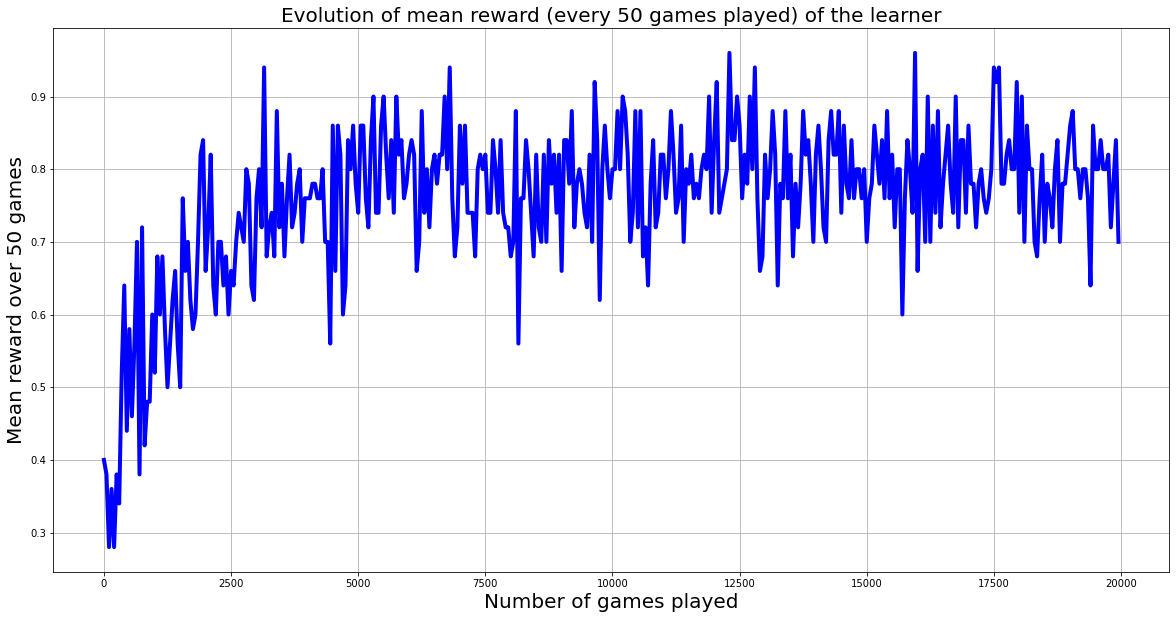

In [141]:
training.plot_mean_reward_during_training()

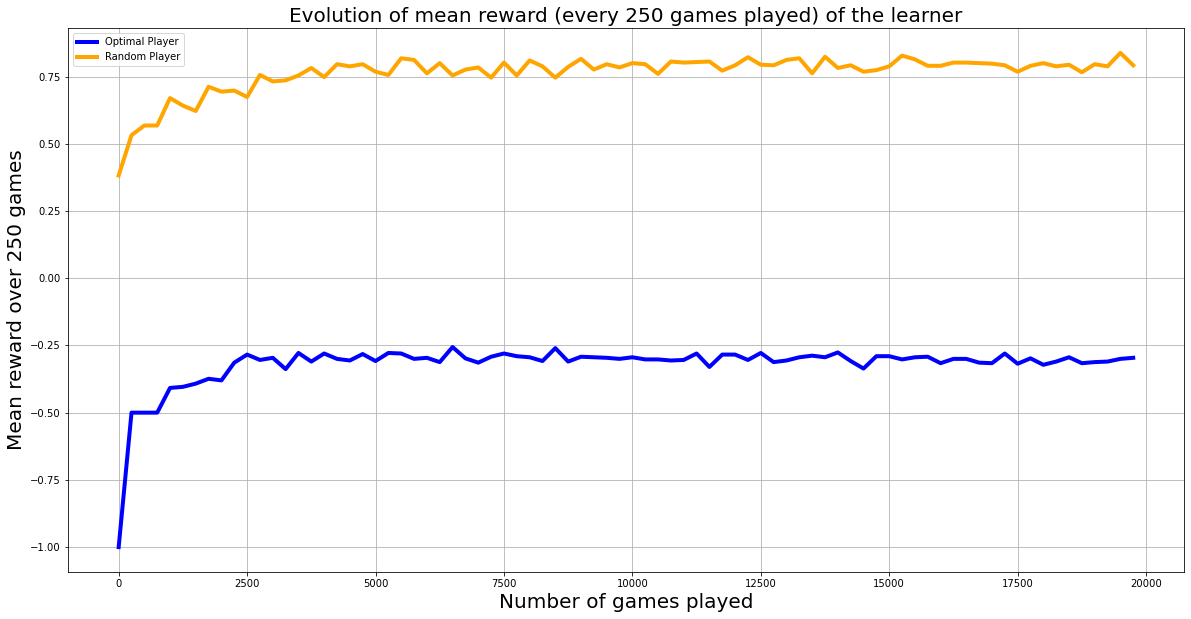

In [142]:
training.plot_mopt_mrng_during_training()

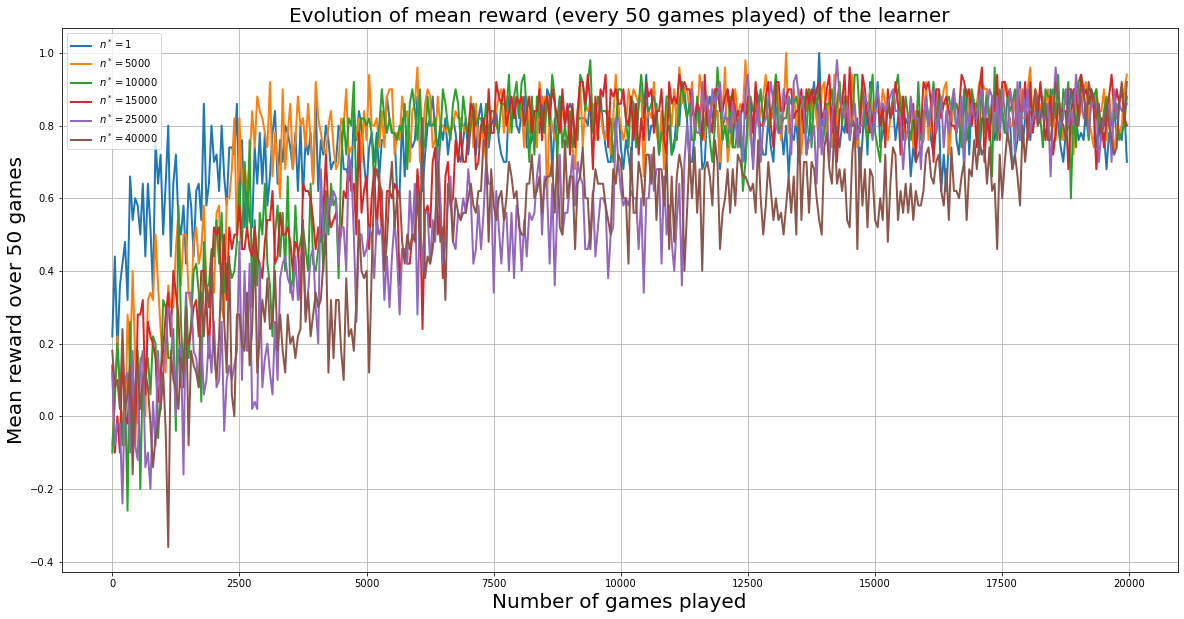

In [148]:
# Question 2.2
n_stars = [1, 5000, 10000, 15000, 25000, 40000]
epsilon_min = 0.1
epsilon_max = 0.8

values = []
names = []
epochs = 0
avg_step = 0

for n_star in n_stars:
    epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star))
    training2 = QTraining(epsilon_greedy_policy)
    training2.train(0.5, run_test=True)
    epochs = training2.epoch
    avg_step = training2.avg_step
    
    values.append(training2.avg_reward)
    names.append(f"$n^*=${n_star}")
    
plots_several_trainings(values, names, avg_step, epochs)